In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import preproc

In [2]:
train = pd.read_csv('price_train.tsv', sep='\t')
house = pd.read_csv('price_housebase.tsv', sep='\t')

In [3]:
train['month'] = pd.to_datetime(train.month)
train.head(1)

,apartment_ratio,offers_in_sites_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio
0,0.0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0


In [4]:
house['latlon'] = list(zip(house.latitude.values, house.longitude.values))

In [5]:
house.head(1)

,beauty_cnt,building_id,building_series_id,shopping_cnt,flats_count,latitude,building_type,cafe_restaurant_eating_out_cnt,unified_address,entertainment_cnt,...,site_id,healthcare_cnt,expect_demolition,longitude,ceiling_height,has_elevator,laundry_and_repair_services_cnt,build_year,city_quadkey,latlon
0,36.0,3031030817531317628,0,45.0,0,55.705219,BRICK,24.0,"Россия, Москва, 1-й Автозаводский проезд, 3",18.0,...,0,16.0,False,37.656994,0.0,True,38.0,1937,120310101302011,"(55.70521926879883, 37.6569938659668)"


In [6]:
train.head(1)

,apartment_ratio,offers_in_sites_ratio,unique_active_buildings_count,avg_price_sqm,month,unique_active_building_series_count,rooms_offered_3_ratio,city_quadkey,median_price_sqm,rooms_offered_4_more_ratio,rooms_offered_1_ratio,total_area_avg,studio_ratio,offer_count,rooms_offered_2_ratio
0,0.0,0.0,1,22727.273438,2018-02-01,1,0.0,120132230303223,22727.273438,0.0,0.0,44.0,0.0,1,1.0


In [195]:
mask = train.groupby("city_quadkey").avg_price_sqm.\
      transform(lambda x : (x > x.mean() - x.std() * 2) & (x < x.mean() + x.std() * 2)).eq(1)

In [207]:
def kill_outlier_prices(train):
    mask = train.groupby("city_quadkey").avg_price_sqm.\
      transform(lambda x : (x > x.mean() - x.std() * 2) & (x < x.mean() + x.std() * 2)).eq(1)
    masked = pd.DataFrame({'is_ok': mask, 'city_quadkey': train.city_quadkey})
    return train.loc[mask | masked.groupby('city_quadkey').is_ok.transform(lambda x: x.sum() <= x.shape[0] / 2.)]

In [208]:
train_clear = kill_outlier_prices(train)

In [287]:
y = train.apartment_ratio
removed_outliers = y.between(y.quantile(.05), y.quantile(.95))

for column in train.columns[1:]:
    
    y = train[column]
    mask = y.between(y.quantile(.01), y.quantile(.99))
    removed_outliers &= mask
    
    print(column, mask.size - mask.sum())

removed_outliers.value_counts()

offers_in_sites_ratio 0
unique_active_buildings_count 1475
avg_price_sqm 3295
month 0
unique_active_building_series_count 787
rooms_offered_3_ratio 0
city_quadkey 3313
median_price_sqm 3322
rooms_offered_4_more_ratio 1661
rooms_offered_1_ratio 0
total_area_avg 3131
studio_ratio 1669
offer_count 1655
rooms_offered_2_ratio 0


True     146201
False     19826
Name: apartment_ratio, dtype: int64

In [488]:
val = pd.read_csv('time.tsv', sep='\t')
val['month'] = pd.to_datetime(val.month)

In [489]:
from scipy.linalg import inv
from datetime import timedelta

def to_time(t):
    return [pd.to_datetime('2017-01-01') +
            timedelta(x) for x in t]

def regression(X, y):
    A = (X - pd.to_datetime('2017-01-01')).apply(lambda x: x.days).values
    A = np.hstack([A.reshape(-1, 1) ** 0, A.reshape(-1, 1), A.reshape(-1, 1) ** 1.3]).astype(float)
    w = inv(A.T @ A + 0.1 * np.eye(A.shape[1])) @ A.T @ y.values.reshape(-1, 1)
    
    x_reg = list(range(0, 365 * 3, 30))
    X_plt = np.array([x_reg]).reshape(-1, 1)
    X_plt = np.hstack([X_plt ** 0, X_plt, X_plt ** 1.3]).astype(float)
    
    return (X_plt, w, to_time(x_reg))

def plot_prices(cnt=5):
    numbers = np.unique(train.city_quadkey.values)
    for i in range(cnt):
        key = np.random.choice(numbers)
        
        df_clear = train_clear.groupby('city_quadkey').get_group(key)
        df = train.groupby('city_quadkey').get_group(key)
        try:
            df_val = val.groupby('city_quadkey').get_group(key)
            
            x_clear, y_clear = df_clear.month, df_clear.avg_price_sqm

            X_clear, w_clear, time = regression(x_clear, y_clear)

            x_clear = x_clear.append(df_val.month)
            y_clear = y_clear.append(df_val.avg_price_sqm)
            
            if df.shape != df_clear.shape:
                x, y = df.month, df.avg_price_sqm
                
                X, w, _ = regression(x, y)
                plt.scatter(x, y)
                plt.plot(time, X @ w)

            plt.axvline(x=pd.to_datetime('2019-08-15'), ymin=0, ymax=y.max())
            plt.scatter(x_clear, y_clear)
            plt.plot(time, X_clear @ w_clear)
        except:
            print(df.shape[0])

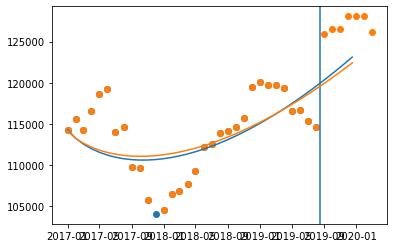

In [542]:
plot_prices(1)

In [452]:
house.loc[np.bitwise_xor(house.unified_address.str.extract(r'(Москва)').isna(),
               house.unified_address.str.extract(r'(\w+, Москва)').isna()).values].unified_address.values

array(['Россия, Московская область, Реутов, шоссе Автомагистраль Москва - Нижний Новгород, 1',
       'Россия, Московская область, Реутов, шоссе Автомагистраль Москва - Нижний Новгород, 11',
       'Россия, Московская область, Сергиево-Посадский городской округ, садовое товарищество Москва, 5',
       'Россия, Московская область, Богородский городской округ, рабочий посёлок имени Воровского, садовое товарищество Вечерняя Москва, 26',
       'Россия, Московская область, городской округ Чехов, СНТ Беляево АПК Москва, 14',
       'Россия, Московская область, городской округ Чехов, СНТ Беляево АПК Москва, 15',
       'Россия, Московская область, городской округ Чехов, СНТ Беляево АПК Москва, 25',
       'Россия, Московская область, городской округ Чехов, СНТ Беляево АПК Москва, 36',
       'Россия, Московская область, городской округ Чехов, СНТ Беляево АПК Москва, 39',
       'Москва, ул. 1-я Квесисская, 9/13'], dtype=object)

In [546]:
house.unified_address.str.extract(r'(\w+, Москва)')

,0
0,"Россия, Москва"
1,"Россия, Москва"
2,"Россия, Москва"
3,"Россия, Москва"
4,"Россия, Москва"
...,...
112198,NaN
112199,NaN
112200,NaN
112201,NaN


In [567]:
def is_moscow(house):
    return 1 - (house.unified_address.str.extract(r'(\w+, Москва)').isna()
            & house.unified_address.str.extract(r'(Москва, ул. 1-я Квесисская, 9/13)').isna()).astype(int)

In [568]:
is_moscow(house).value_counts()

0    66495
1    45708
dtype: int64

In [569]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.data import load_data
from utils.model import XGBModel
from utils.pipeline import pipeline, get_data

In [590]:
PATH = ''
base = pd.read_csv(PATH + 'price_housebase.tsv', sep='\t')
train = pd.read_csv(PATH + 'price_train.tsv', sep='\t')
test = pd.read_csv(PATH + 'price_test.tsv', sep='\t')